# Titanic Project

This notebook is my attempt to solve the Titanic problem from Kaggle: 

>https://www.kaggle.com/competitions/titanic/overview

## 1. Problem definition

Use ML to predict wheather a passanger survived the Titanic crash or not. 

## 2. Data

I will be using data from Kaggle competition:

> https://www.kaggle.com/competitions/titanic/data

## 3. Evaluation Metrics 

I will be scoring my model using method required by Kaggle: accuracy

>https://www.kaggle.com/competitions/titanic/overview/evaluation

## 4. Features

**Data dictionary:**

* survival - Survival	(0 = No, 1 = Yes)
* pclass - Ticket class	(1 = 1st, 2 = 2nd, 3 = 3rd)
* sex - sex	
* Age	- Age in years	
* sibsp -	number of siblings / spouses aboard the Titanic	
* parch - number of parents / children aboard the Titanic	
* ticket - Ticket number	
* fare - Passenger fare	
* cabin - Cabin number	
* embarked - Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [1]:
# Importing all the tools we will be using 

# Regular EDA (Exploratory data analysis) and ploting librarnies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#we want our plots to appear inside the notebook
%matplotlib inline 

# StandardScaler
from sklearn.preprocessing import StandardScaler

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

Install Imbalanced-learn library (to do that turn this cell into code)

pip install imbalanced-learn

## 5. Load and Explore the data

In [2]:
df = pd.read_csv("train.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


From the dataFrame we can see, that the `Survived` is our target column. We will need to remove all the missing values from this column. We will also have to figure out a way to handle `Names` and `Cabin` - I think we can just remove them, since encoding them will create too much chaos and we have other unique values in our dataset. We will also heve to encode `Sex` and `Embarked`. Idealy we want to create one function to take care of all the transformations.

In [3]:
# Let's check how many missing values we have
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We are missing a lot of rows in `Age` and `Cabin`columns. 
We can do the following to tacke this:
* Fill the `Age` column with the median of age 
* Remove `Cabin` column (for now)

In [4]:
# Let's find out how many survivors there are
df["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [5]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### 5.1 Create data preprocessing function

For more data analisys we will need to encode the data, so let's create a function that will:
* Remove `Ticket`, `Name` and `Cabin`
* Add an if statment to remove the survived dropna operation if the data frame is not a test set
* Remove all missing rows where `Survived` has a missing value
* Fil the `Age` column with the median of age
* Encode missing `Embarked` values to `unknown`
* Encode `Sex` and `Embarked` using `OneHotEncoder()`

In [6]:
def checkIfNaN(str):
    return str != str
def get_df_ready(df, isTestSet=False):
    # Remove all the missing values from Survived column if the dataFrame is not a test set
    if(isTestSet==False):
        df.dropna(subset=["Survived"], inplace=True) 
    
    # Remove the Name and Ticket column
    df = df.drop("Ticket", axis=1)
    df = df.drop("Name", axis=1)
    df = df.drop("Cabin", axis=1)
    
    # Fill the missing values:
    df["wasAgeMissing"] = False
    age_median = df["Age"].median()
    # Fill in the missing values with median        
    df["Age"].fillna(age_median, inplace=True)
    # Add a column that indicated if the Age value was a NaN
    for i in range(0,891):
        if df["Age"][i]== age_median:
            df["wasAgeMissing"][i] = True
        else:
            df["wasAgeMissing"][i] = False
    
#     #Fill in the missing values of Cabin with unknown
#     df["wasCabinMissing"] = False
#     df["Cabin"].fillna("unknown", inplace=True)
#     for i in range(0,891):
#         if df["Cabin"][i]=="unknown":
#             df["wasCabinMissing"][i] = True
#         else:
#             df["wasCabinMissing"][i] = False
            
    
#     # Turn Sex and Embarked into categories dtype
#     for content in df["Embarked"]:
#         if pd.api.types.is_string_dtype(content):
#             df["Embarked"] = pd.Categorical(df["Embarked"])   
            
#     for label, content in df.items():
#         if pd.api.types.is_string_dtype(content):
#             df[label] = content.astype("category").cat.as_ordered()

#     # Turn Cabin into category
#     df["Cabin"] = df["Cabin"].astype("category")

    df = pd.get_dummies(df, prefix=["Sex", "Embarked"], columns=["Sex", "Embarked"])
    # Change 0 and 1 into True and false values 
    dummies_column_names = {"Sex_female", "Sex_male", "Embarked_C", "Embarked_Q", "Embarked_S"}
    for i in range(0, 891):
        for column in dummies_column_names:
            if df[column][i] == 1:
                df[column][i] = True
            else:
                df[column][i] = False
    
    # Make sure the dtype in these columns is bool
    for column in dummies_column_names:
        df[column] = df[column].astype("bool")
            
    # return 
    return df

In [7]:
transformed_df = get_df_ready(df, isTestSet=False)
transformed_df.info()

C:\Users\jakub\AppData\Local\Temp\ipykernel_13416\3211436174.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["wasAgeMissing"][i] = False
C:\Users\jakub\AppData\Local\Temp\ipykernel_13416\3211436174.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["wasAgeMissing"][i] = True
C:\Users\jakub\AppData\Local\Temp\ipykernel_13416\3211436174.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][i] = False
C:\Users\jakub

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Age            891 non-null    float64
 4   SibSp          891 non-null    int64  
 5   Parch          891 non-null    int64  
 6   Fare           891 non-null    float64
 7   wasAgeMissing  891 non-null    bool   
 8   Sex_female     891 non-null    bool   
 9   Sex_male       891 non-null    bool   
 10  Embarked_C     891 non-null    bool   
 11  Embarked_Q     891 non-null    bool   
 12  Embarked_S     891 non-null    bool   
dtypes: bool(6), float64(2), int64(5)
memory usage: 54.1 KB


In [8]:
# Let's see if we still have any non-numerical data
transformed_df.dtypes

PassengerId        int64
Survived           int64
Pclass             int64
Age              float64
SibSp              int64
Parch              int64
Fare             float64
wasAgeMissing       bool
Sex_female          bool
Sex_male            bool
Embarked_C          bool
Embarked_Q          bool
Embarked_S          bool
dtype: object

In [9]:
transformed_df

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,wasAgeMissing,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,False,False,True,False,False,True
1,2,1,1,38.0,1,0,71.2833,False,True,False,True,False,False
2,3,1,3,26.0,0,0,7.9250,False,True,False,False,False,True
3,4,1,1,35.0,1,0,53.1000,False,True,False,False,False,True
4,5,0,3,35.0,0,0,8.0500,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,13.0000,False,False,True,False,False,True
887,888,1,1,19.0,0,0,30.0000,False,True,False,False,False,True
888,889,0,3,28.0,1,2,23.4500,True,True,False,False,False,True
889,890,1,1,26.0,0,0,30.0000,False,False,True,True,False,False


### 5.2 Spliting the data

In [10]:
# Let's create X and Y
X = transformed_df.drop("Survived", axis=1)
y = transformed_df["Survived"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 5.3 Creating a balanced version of our data

We saw earlier, that we have over 500 "non-survivors" and about 300 survivors. I was curious if balancing them would make any difference like making the model better with new data. I did a little reaserch about dealing with imbalanced data and came across this article on Medium: 
> https://medium.com/analytics-vidhya/machine-learning-how-to-handle-class-imbalance-920e48c3e970

In the article the following method was mentioned - `SMOTE()`. I searched it and found this article (in Polish):
> https://miroslawmamczur.pl/niezbalansowane-dane-klasyfikacyjne-na-ratunek-smote/

I also used this guid from Imblearn library:
> https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn

In [11]:
# Implementing the SMOTE function to balcance our data
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, n_jobs=-1) 
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

C:\Users\jakub\Small-ML-Projects\env\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Now our data is ready and since we have to versions of it we will do the following:
1. Fit the models on the non-balanced data and score them
2. Tune these models and see which one performs the best
3. Fit the models again but on the balance data
4. Tune the models trained on balanced data
5. Emarge the best model of all

## 6. Choosing the model
Now since all of our data is ready and split we can move on to picking models. We will check the scikit learn map to see which model could we use: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html 

We are going to try:
* LinearSVC (https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
* SVC (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
* KNN (https://scikit-learn.org/stable/modules/neighbors.html)
* LogisticRegression (https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)
* RandomForestClassifier (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
* AdaBoost (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier)

**Note:** Remember to import all the models!!!

Because we want to try so many different models we will create a dictionary with all of our models, fit them and evaluate them using accuracy. 

In [12]:
# Import all the models 
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [13]:
# Create a model dictionary
model_dict = {
    "LinearSVC": LinearSVC(),
    "SVC": SVC(),
    "KNN": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier()
}

### 6.1 Scoring the models

Now let's create a function that will:
* take model dictionary as a parameter
* fit all the model to our data
* score all the models using accuracy
* put the name and the score of the model in results dictionary
* return the results dictionary

In [14]:
# Create fit_and_score function
def fit_and_score(model_dictionary, X_train = X_train, y_train = y_train):
    """
    This function takes as an input a dictionary of models, fits and scoress all of the models using accuracy.
    """
    # Set random seed
    np.random.seed(42)
    
    # Create an empty results dictionary 
    results = {}
    
    for name, model in model_dictionary.items():
        # Fit the model
        model.fit(X_train, y_train)
        # Score the model using accuracy and add the results
        results[name] = cross_val_score(model, X_test, y_test, cv=5, scoring="accuracy").mean()
    # Return the results dictionary
    return results

**Note:** I have decided to add the `%%time` magic function to monitor how long does it take for columns to run. 

In [15]:
%%time
# Let's call our function
models_score = fit_and_score(model_dict, X_train, y_train)

C:\Users\jakub\Small-ML-Projects\env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jakub\Small-ML-Projects\env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jakub\Small-ML-Projects\env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jakub\Small-ML-Projects\env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jakub\Small-ML-Projects\env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jakub\Small-ML-Projects\env\lib\site-packages\sklearn\svm\_base.py:1225

CPU times: total: 156 ms
Wall time: 1.29 s


In [16]:
models_score

{'LinearSVC': 0.6698412698412698,
 'SVC': 0.6201587301587301,
 'KNN': 0.6477777777777778,
 'LogisticRegression': 0.743015873015873,
 'RandomForestClassifier': 0.7653968253968254,
 'AdaBoostClassifier': 0.6922222222222223}

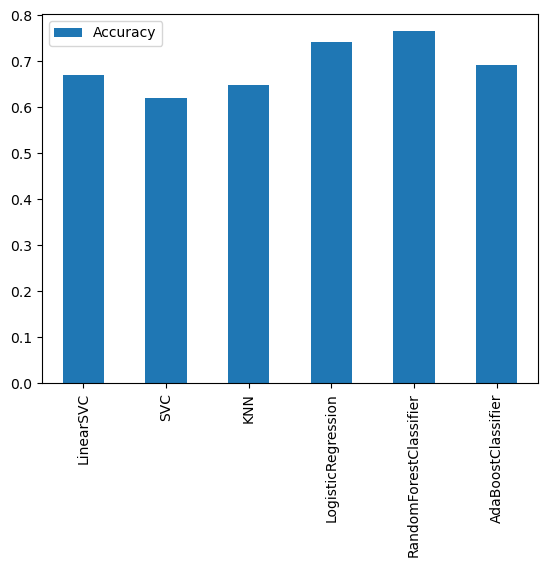

In [17]:
# Let's visualize the results
models_score_df = pd.DataFrame(models_score, index=["Accuracy"])
models_score_df.T.plot.bar();

## 7. Hyperparameter tuning

Some of our model did quite well, but some did below our expectations. We got a lot of warnings saying we should increase the number of iterators to get better results. These warnings were for:
* LinearSVC 
* LogisticRegression

Our target is to get as highest score we can get and pick a model with the highest score.

### 7.1 Hyperparameter tuning for SVC

I will try to optimize `SVC` using `GridSearchCV` to see if we can get more out of it since it's performing the worst.
I did some reaserch on how can I improve my `SVC` model and came across this article on Medium: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769

**Note:** This and next `GridSearchCV`s will run for a long time. I think it may be a good idea to save each model after we run the `GridSearchCV`. Remember - the `%%time` magic function will tell you exactly how long did the cell run for. Before runing the code make sure you have something else to do while waiting for this code to run. 

**Note:** The cell below was runing for almost 10 hours without a result, so it's either broken or it just takes this long for my laptop to process. 

%%time
# GridSearchCV for SVC
svc_grid = {"C": (0.1, 1, 10, 100, 1000),
            "gamma": (0.1, 1, 10, 100),
            "kernel": ("linear", "rbf", "poly")}

# Setup GridSearchCV for SVC
gs_svc = GridSearchCV(SVC(),
                      param_grid=svc_grid,
                      cv=5,
                      verbose=True)
gs_svc.fit(X_train, y_train)

gs_svc.best_params_

In [18]:
# Let's create a dictionary, where we will store updated models' values
updated_models_scores = {}

updated_models_scores["SVC"] = gs_svc.score(X_test, y_test)

We can see a big improvement in our SVC model, but it's still performing similarly to other models baseline score, so I think we will park this model for now.

### 7.2 Hyperparameter tuning for LogisticRegression

Next up is `LogisticRegression()`. The baseline score is quite high already, so I have some high hopes for this one.

My picks for grid are based on this article from Medium: 
> https://medium.com/codex/do-i-need-to-tune-logistic-regression-hyperparameters-1cb2b81fca69

In [19]:
%%time
np.random.seed(42)
# Setup GridSearchCV for LogisticRegression
logistic_regression_grid = {"C": (0.1, 1, 10, 100, 1000),
                            "max_iter": np.arange(100,1000,10)}
gs_logistic_regression = GridSearchCV(LogisticRegression(n_jobs=-1),
                                      param_grid=logistic_regression_grid,
                                      cv=5,
                                      verbose=True,
                                      n_jobs=-1)
gs_logistic_regression.fit(X_train, y_train);

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
CPU times: total: 4.11 s
Wall time: 56.5 s


GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1), n_jobs=-1,
             param_grid={'C': (0.1, 1, 10, 100, 1000),
                         'max_iter': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
       230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350,
       360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480,
       490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610,
       620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740,
       750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870,
       880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990])},
             verbose=True)

In [20]:
gs_logistic_regression.best_params_

{'C': 0.1, 'max_iter': 290}

In [21]:
# Let's score the model and add the new score to our updated scores dictionary
updated_models_scores["LogisticRegression"] = gs_logistic_regression.score(X_test, y_test)
updated_models_scores["LogisticRegression"], models_score["LogisticRegression"]

(0.770949720670391, 0.743015873015873)

There is no improvement in `LogisticRegression()`, in fact I think I performed worst (I'm not sure how), so we will move on to the next one.

### 7.3 Hyperparameter tuning for LinearSVC

For my picks to the grid I used this article: 
> https://medium.com/grabngoinfo/support-vector-machine-svm-hyperparameter-tuning-in-python-a65586289bcb

(I skiped the `kernel`, because then some of the other values would not work - you will see what I mean if you take a look at the article above).

In [22]:
%%time
np.random.seed(42)
# Setup GridSearchCV for LinearnSVC
linear_svc_grid = {"C": (0.1, 1, 10, 100, 1000)}
gs_linear_svc = GridSearchCV(LinearSVC(),
                             param_grid=linear_svc_grid,
                             cv=5,
                             verbose=True, 
                             n_jobs=-1)
gs_linear_svc.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 31.2 ms
Wall time: 251 ms


C:\Users\jakub\Small-ML-Projects\env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': (0.1, 1, 10, 100, 1000)}, verbose=True)

In [23]:
gs_linear_svc.best_params_

{'C': 1000}

In [24]:
# Add to updated scores dictionary 
updated_models_scores["LinearSVC"] = gs_linear_svc.score(X_test, y_test)
updated_models_scores["LinearSVC"], models_score["LinearSVC"]

(0.6536312849162011, 0.6698412698412698)

There is an improvement and it's quite big. Mayby if I tried more hyperparameters, or had data shaped the other way or used optimizers the score would be higher. I tried searching with different number of iterations - `max_iter`, but my model scored way lower, so I just removed the option for searching with `max_iter`. The best result I could get was with `"C"=1000`. 

### 7.4 Hyperparameter tuning dor RandomForestClassifier

We can still try to improve hyperparameters for `RandomForestClassifier()` and `AdaBoostClassifier()`. We will start with the first one. I used this article to pick my values for the grid: 
> https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6

**Note:** This cell, at least on my computer, takes a little bit less than two hours (1h and 40min) to run so before you run it make sure you have something else to do.

In [25]:
%%time
np.random.seed(42)
# Setup GridSearchCV for RandomForestClassifier
random_forest_clf_grid = {"n_estimators": np.arange(100, 2000, 100),
                          "max_depth": (5, 8, 15, 25, 30),
                          "min_samples_split": (2, 5, 10, 15, 100),
                          "min_samples_leaf": (1, 2, 5, 10)}
gs_random_forest_clf = GridSearchCV(RandomForestClassifier(n_jobs=-1),
                                    param_grid=random_forest_clf_grid,
                                    cv=5,
                                    verbose=True,
                                    n_jobs=-1)
gs_random_forest_clf.fit(X_train, y_train)

Fitting 5 folds for each of 1900 candidates, totalling 9500 fits
CPU times: total: 32.6 s
Wall time: 1h 43min 6s


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': (5, 8, 15, 25, 30),
                         'min_samples_leaf': (1, 2, 5, 10),
                         'min_samples_split': (2, 5, 10, 15, 100),
                         'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900])},
             verbose=True)

In [26]:
gs_random_forest_clf.best_params_

{'max_depth': 25,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [27]:
# Add the score to dictionary
updated_models_scores["RandomForestClassifier"] = gs_random_forest_clf.score(X_test, y_test)
updated_models_scores

{'LogisticRegression': 0.770949720670391,
 'LinearSVC': 0.6536312849162011,
 'RandomForestClassifier': 0.8044692737430168}

In [28]:
# Let's save our improved model in case something goes wrong
import pickle
pickle.dump(gs_random_forest_clf, open("gs_random_forest_clf_1.pkl", "wb"))

In [29]:
import pickle
loaded_random_forest_clf = pickle.load(open("gs_random_forest_clf_1.pkl", "rb"))
updated_models_scores["RandomForestClassifier"] = loaded_random_forest_clf.score(X_test, y_test)

### 7.5 Hyperparemeter tuning for AdaBoostClassifier

Now we can tune the hyperparameters for our last model - `AdaBoostClassifier()`. I used this article to help me decide which hyperparameters should I try: 
> https://medium.com/@chaudhurysrijani/tuning-of-adaboost-with-computational-complexity-8727d01a9d20

In [30]:
%%time
np.random.seed(42)
# Setup GridSearchCV for AdaBoostClassiffier
ada_boost_clf_grid = {"n_estimators": (10, 50, 100, 500, 1000, 5000),
                      "learning_rate": np.arange(0.1, 2.1, 0.1)}
gs_ada_boost_clf = GridSearchCV(AdaBoostClassifier(),
                                param_grid=ada_boost_clf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)
gs_ada_boost_clf.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
CPU times: total: 2.05 s
Wall time: 5min 58s


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
                         'n_estimators': (10, 50, 100, 500, 1000, 5000)},
             verbose=True)

In [31]:
# Add the score to dictionary
updated_models_scores["AdaBoostClassifier"] = gs_ada_boost_clf.score(X_test, y_test)
updated_models_scores["AdaBoostClassifier"], models_score["AdaBoostClassifier"]

(0.7597765363128491, 0.6922222222222223)

### 7.6 View the results 

In [32]:
# Viev the updated models' scores 
updated_models_scores

{'LogisticRegression': 0.770949720670391,
 'LinearSVC': 0.6536312849162011,
 'RandomForestClassifier': 0.8044692737430168,
 'AdaBoostClassifier': 0.7597765363128491}

In [33]:
# Create a data frame of models scores so we can compare them
models_scores_df = pd.DataFrame([models_score, updated_models_scores])
models_scores_df

,LinearSVC,SVC,KNN,LogisticRegression,RandomForestClassifier,AdaBoostClassifier
0,0.669841,0.620159,0.647778,0.743016,0.765397,0.692222
1,0.653631,NaN,NaN,0.770950,0.804469,0.759777


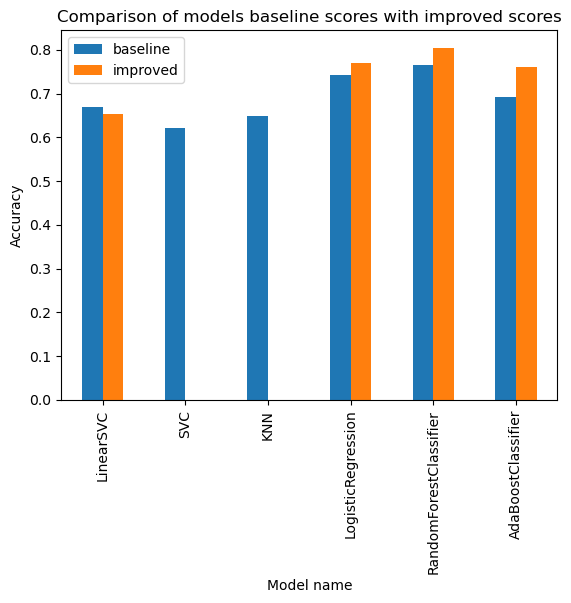

In [34]:
# Visualize the models scores and compare them
plot = models_scores_df.T.plot.bar();
plt.legend(['baseline', 'improved']);
plt.title("Comparison of models baseline scores with improved scores")
plt.xlabel("Model name")
plt.ylabel("Accuracy")
plt.savefig("Models_scores_comperation.jpg")

From the graph above we can clearly se that the impoved `RandomForestClassiffier` is performing the best out of all with about 93% accuracy! 

## 8. Hyperparameter tuning for balanced data

We want to see if oversampling we performed earlier makes actuall difference and is it worth it.

**Quick note:** for all the hyperparameter tuning I will be using the same code as earlier. 

In [35]:
%%time
np.random.seed(42)
# Let's see how our model performs on balanced data
models_score_smote = fit_and_score(model_dict, X_train_smote, y_train_smote);
models_score_smote

C:\Users\jakub\Small-ML-Projects\env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jakub\Small-ML-Projects\env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jakub\Small-ML-Projects\env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jakub\Small-ML-Projects\env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jakub\Small-ML-Projects\env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jakub\Small-ML-Projects\env\lib\site-packages\sklearn\svm\_base.py:1225

CPU times: total: 188 ms
Wall time: 1.25 s


{'LinearSVC': 0.6698412698412698,
 'SVC': 0.6201587301587301,
 'KNN': 0.6477777777777778,
 'LogisticRegression': 0.743015873015873,
 'RandomForestClassifier': 0.7653968253968254,
 'AdaBoostClassifier': 0.6922222222222223}

We can already see that some models performed better, but some did worst.

In [36]:
# Create an empty dictionary for new results to compare later on
updated_models_score_smote = {}

### 8.1 Hyperparameter tuning dor SVC with balanced data

%%time
# GridSearchCV for SVC
svc_grid = {"C": (0.1, 1, 10, 100, 1000),
            "gamma": (0.1, 1, 10, 100),
            "kernel": ("linear", "rbf", "poly")}

# Setup GridSearchCV for SVC
gs_svc_smote = GridSearchCV(SVC(),
                      param_grid=svc_grid,
                      cv=5,
                      verbose=True)
gs_svc_smote.fit(X_train_smote, y_train_smote);
updated_models_scores_smote["SVC"] = gs_svc_smote.score(X_test, y_test)
updated_models_scores_smote

### 8.2 Hyperparameter tuning for LogisticRegression with balanced data

In [37]:
%%time
np.random.seed(42)
# Setup GridSearchCV for LogisticRegression
logistic_regression_grid = {"C": (0.1, 1, 10, 100, 1000),
                            "max_iter": np.arange(100,1000,10)}
gs_logistic_regression_smote = GridSearchCV(LogisticRegression(n_jobs=-1),
                                      param_grid=logistic_regression_grid,
                                      cv=5,
                                      verbose=True,
                                      n_jobs=-1)
gs_logistic_regression_smote.fit(X_train_smote, y_train_smote);
updated_models_score_smote["LogisticRegression"] = gs_logistic_regression_smote.score(X_test, y_test)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
CPU times: total: 6.12 s
Wall time: 1min 10s


### 8.3 Hyperparameter tuning for LinearSVC with balanced data

In [38]:
%%time
np.random.seed(42)
# Setup GridSearchCV for LinearnSVC
linear_svc_grid = {"C": (0.1, 1, 10, 100, 1000)}
gs_linear_svc_smote = GridSearchCV(LinearSVC(),
                             param_grid=linear_svc_grid,
                             cv=5,
                             verbose=True, 
                             n_jobs=-1)
gs_linear_svc_smote.fit(X_train_smote, y_train_smote);
updated_models_score_smote["LinearSVC"] = gs_linear_svc_smote.score(X_test, y_test)
updated_models_score_smote

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 46.9 ms
Wall time: 292 ms


C:\Users\jakub\Small-ML-Projects\env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'LogisticRegression': 0.7486033519553073, 'LinearSVC': 0.6201117318435754}

### 8.4 Hyperparameter tuning for RandomForestClassifier with balanced data

In [39]:
%%time
np.random.seed(42)
# Setup GridSearchCV for RandomForestClassifier
random_forest_clf_grid = {"n_estimators": np.arange(100, 2000, 100),
                          "max_depth": (5, 8, 15, 25, 30),
                          "min_samples_split": (2, 5, 10, 15, 100),
                          "min_samples_leaf": (1, 2, 5, 10)}
gs_random_forest_clf_smote = GridSearchCV(RandomForestClassifier(n_jobs=-1),
                                    param_grid=random_forest_clf_grid,
                                    cv=5,
                                    verbose=True,
                                    n_jobs=-1)
gs_random_forest_clf_smote.fit(X_train_smote, y_train_smote);
updated_models_score_smote["RandomForestClassifier"] = gs_random_forest_clf_smote.score(X_test, y_test)
updated_models_score_smote

Fitting 5 folds for each of 1900 candidates, totalling 9500 fits
CPU times: total: 33.7 s
Wall time: 1h 47min 7s


{'LogisticRegression': 0.7486033519553073,
 'LinearSVC': 0.6201117318435754,
 'RandomForestClassifier': 0.776536312849162}

### 8.5 Hyperparameter tuning for AdaBoostClassifier with balanced data

In [40]:
%%time
np.random.seed(42)
# Setup GridSearchCV for AdaBoostClassiffier
ada_boost_clf_grid = {"n_estimators": (10, 50, 100, 500, 1000, 5000),
                      "learning_rate": np.arange(0.1, 2.1, 0.1)}
gs_ada_boost_clf_smote = GridSearchCV(AdaBoostClassifier(),
                                param_grid=ada_boost_clf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)
gs_ada_boost_clf_smote.fit(X_train_smote, y_train_smote); 
updated_models_score_smote["AdaBoostClassifier"] = gs_ada_boost_clf_smote.score(X_test, y_test)
updated_models_score_smote

Fitting 5 folds for each of 120 candidates, totalling 600 fits
CPU times: total: 3.53 s
Wall time: 6min 18s


{'LogisticRegression': 0.7486033519553073,
 'LinearSVC': 0.6201117318435754,
 'RandomForestClassifier': 0.776536312849162,
 'AdaBoostClassifier': 0.7597765363128491}

### 8.6 Visualizing the results

In [41]:
# Create a data frame of models scores so we can compare them
models_scores_smote_df = pd.DataFrame([models_score_smote, updated_models_score_smote])
models_scores_smote_df

,LinearSVC,SVC,KNN,LogisticRegression,RandomForestClassifier,AdaBoostClassifier
0,0.669841,0.620159,0.647778,0.743016,0.765397,0.692222
1,0.620112,NaN,NaN,0.748603,0.776536,0.759777


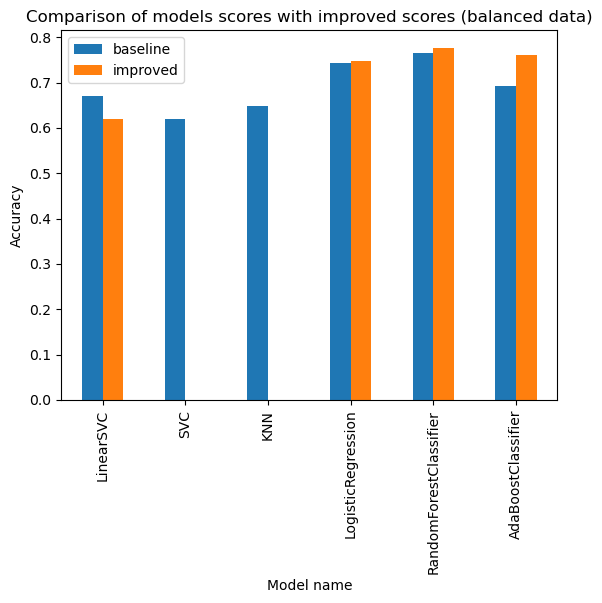

In [42]:
# Visualize the models scores and compare them
plot = models_scores_smote_df.T.plot.bar();
plt.legend(['baseline', 'improved']);
plt.title("Comparison of models scores with improved scores (balanced data)")
plt.xlabel("Model name")
plt.ylabel("Accuracy")
plt.savefig("Models_scores_with_smote_comperation.jpg")

## 9. Making final predictions

In [43]:
# Import the test data
test_df = pd.read_csv("test.csv")
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [44]:
# Transforming test_df using our fuction
transformed_test_df = get_df_ready(test_df, isTestSet=True)
transformed_test_df

C:\Users\jakub\AppData\Local\Temp\ipykernel_13416\3211436174.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["wasAgeMissing"][i] = False
C:\Users\jakub\AppData\Local\Temp\ipykernel_13416\3211436174.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["wasAgeMissing"][i] = True


KeyError: 418

In [ ]:
transformed_test_df.isna().sum()

In [ ]:
transformed_test_df.remainder__Fare.fillna(value=transformed_test_df.remainder__Fare.median(), inplace=True)
transformed_test_df.isna().sum()

In [ ]:
X_train

There is a small problem, because in our training dataset we had a column embarked_unknown because we had missing values. In the test dataset we don't have this issue, so we are missing one column, which i will add mannualy and it will be filled with zeros. 

In [ ]:
# Adding that one missing column and setting all the values to 0, because there were no NaNs in the Embarked column
transformed_test_df["one_hot__Embarked_unknown"] = 0

# Reorder the dataFrame as the original, training one
transformed_test_df = transformed_test_df[["one_hot__Sex_female", "one_hot__Sex_male", "one_hot__Embarked_C", "one_hot__Embarked_Q", "one_hot__Embarked_S","one_hot__Embarked_unknown","remainder__PassengerId","remainder__Pclass","remainder__Age","remainder__SibSp","remainder__Parch","remainder__Fare"]]

Now everything seems to be okay.

In [ ]:
# Make predictions
predictions = loaded_random_forest_clf.predict(transformed_test_df)
predictions

In [ ]:
# Create a data frame so we can export predictions to .csv file later
predictions_df = pd.DataFrame(columns=("PassengerId", "Survived"))

In [ ]:
# Add data to the predictions_df and change values into integers
predictions_df["PassengerId"] = transformed_test_df["remainder__PassengerId"].astype(int)
predictions_df["Survived"] = predictions.astype(int)

In [ ]:
predictions_df

In [ ]:
# Set the index od the data frame to PassengerId so that our data frame has the required shape 
predictions_df.set_index("PassengerId", inplace=True)
predictions_df

In [ ]:
# Create a .csv file from the predictions_df 
#predictions_df.to_csv("predictions.csv")

## The end

In conclusion we have created a model with 93% accuracy. Here are some things that could be improved:
* Changing `Sex` column into 1 if female and 0 if male (saving some space)
* Adding optimizers to our models
* Adding some data standarization function

Thank You for reading!

This notebook was made by Jakub Kuliński 03.05.2023 